### 01_loading&preprocessing_h5ad 

#### Preprocessing and quality control of SEA-AD single-cell data

#### Overview

This iPython notebook processes single-nucleus RNA sequencing (snRNA-seq) data from the **Seattle Alzheimer’s Disease Brain Cell Atlas (SEA-AD)**, specifically from the **middle temporal gyrus (MTG)** of human brains. The dataset includes cells from both **Alzheimer’s disease (AD) patients and controls.**

#### Objectives

1. Load and preprocess the .h5ad dataset from the SEA-AD Atlas.
2. Perform quality control to remove low-quality cells based on:
- Gene count thresholds: Cells with extreme gene counts are removed based on data-driven quantile thresholds.
- Mitochondrial gene content: Cells with high mitochondrial RNA percentages (apoptotic cells) are filtered out dynamically by detecting genes prefixed with "MT-".
4. Normalize gene expression to ensure comparability across cells.
5. Evaluate data distributions before and after preprocessing using statistical summaries, histograms, boxplots, and correlation matrices.

#### Required libraries

Before running this notebook, ensure that the following libraries are installed:

```python
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
```

Notes

- This preprocessing step ensures that the dataset is clean and ready for downstream analyses. 
- The filtering thresholds are data-driven, meaning they are defined dynamically rather than using arbitrary cutoffs.

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Define file paths
data_raw_path = "/home/silvanac/NeuroNet_AD/data/raw/whole_taxonomy_MTG_AD.h5ad"

# Load the dataset without loading everything into RAM
adata = sc.read_h5ad(data_raw_path, backed="r")

# View dataset dimensions
print(adata.shape)

(1378211, 36412)


In [3]:
# Extract a sample of 5000 cells to work with
adata_sample = adata[:5000, :].to_memory()

# Verify the new sample
print(adata_sample.shape)

(5000, 36412)


In [4]:
# Check the columns present in adata_sample.obs before making modifications
print("Columns in adata_sample.obs before correction:")
print(adata_sample.obs.columns)

# Define the total_counts column with the total number of RNA molecules detected in each cell
adata_sample.obs["total_counts"] = adata_sample.obs["Number of UMIs"]

# Confirm that 'total_counts' has been successfully added
print("Columns in adata_sample.obs after adding 'total_counts':")
print(adata_sample.obs.columns)

Columns in adata_sample.obs before correction:
Index(['assay_ontology_term_id', 'cell_type_ontology_term_id',
       'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
       'organism_ontology_term_id', 'sex_ontology_term_id',
       'tissue_ontology_term_id', 'is_primary_data', 'Neurotypical reference',
       'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education',
       'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score',
       'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage',
       'Microinfarct pathology', 'Specimen ID', 'donor_id', 'PMI',
       'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs',
       'suspension_type', 'development_stage_ontology_term_id',
       'Continuous Pseudo-progression Score', 'tissue_type', 'cell_type',
       'assay', 'disease', 'organism', 'sex', 'tissue',
       'self_reported_ethnicity', 'development_stage', 'observation_joinid'],
      dtype='object')
Columns

In [5]:
# Identify mitochondrial genes in the feature matrix  
# We assume that mitochondrial genes have the prefix "MT-"  
adata_sample.var["mt"] = adata_sample.var["feature_name"].str.startswith("MT-")

# Count the total number of mitochondrial genes detected  
print(f"Number of mitochondrial genes identified: {adata_sample.var['mt'].sum()}")

# Calculate the amount of mitochondrial RNA expressed in each cell  
mt_counts = adata_sample[:, adata_sample.var["mt"]].X.sum(axis=1)

# Ensure that mt_counts is a one-dimensional array  
if isinstance(mt_counts, np.matrix) or len(mt_counts.shape) > 1:
    mt_counts = np.asarray(mt_counts).flatten()

# Calculate the percentage of mitochondrial RNA in each cell  
adata_sample.obs["pct_counts_mt"] = (mt_counts / adata_sample.obs["total_counts"].values) * 100

# Verify that the relevant columns have been correctly generated  
print("Final columns in adata_sample.obs:")
print(adata_sample.obs.columns)

Number of mitochondrial genes identified: 13
Final columns in adata_sample.obs:
Index(['assay_ontology_term_id', 'cell_type_ontology_term_id',
       'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
       'organism_ontology_term_id', 'sex_ontology_term_id',
       'tissue_ontology_term_id', 'is_primary_data', 'Neurotypical reference',
       'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education',
       'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score',
       'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage',
       'Microinfarct pathology', 'Specimen ID', 'donor_id', 'PMI',
       'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs',
       'suspension_type', 'development_stage_ontology_term_id',
       'Continuous Pseudo-progression Score', 'tissue_type', 'cell_type',
       'assay', 'disease', 'organism', 'sex', 'tissue',
       'self_reported_ethnicity', 'development_stage', 'observation_joinid

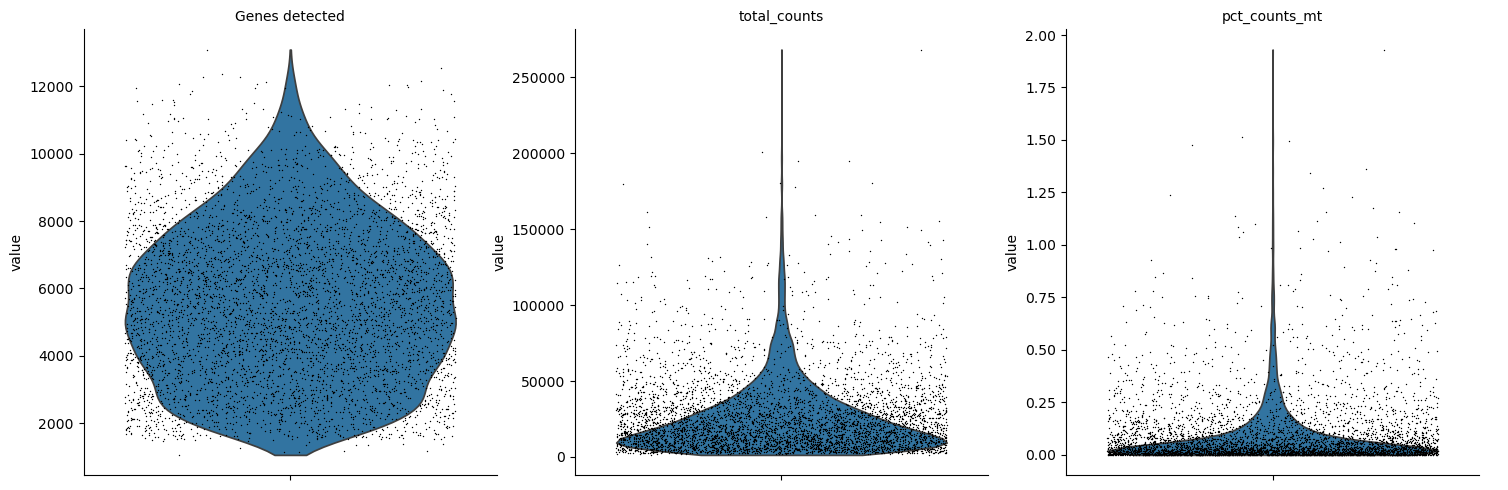

In [6]:
# Generate violin plots to visualize the distribution of key metrics per cell  
sc.pl.violin(
    adata_sample,
    ["Genes detected", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True
)

In [7]:
# Check for the presence of null or missing values  
print(adata_sample.obs[["Genes detected", "total_counts", "pct_counts_mt"]].isnull().sum())

Genes detected    0
total_counts      0
pct_counts_mt     0
dtype: int64


In [8]:
# Get basic descriptive statistics   
print(adata_sample.obs[["Genes detected", "total_counts", "pct_counts_mt"]].describe())

       Genes detected   total_counts  pct_counts_mt
count     5000.000000    5000.000000    5000.000000
mean      5548.010200   26042.734600       0.091414
std       2305.150351   24477.110607       0.155427
min       1056.000000    1398.000000       0.000000
25%       3703.000000    9730.250000       0.011288
50%       5434.000000   18803.000000       0.034830
75%       7180.250000   33594.250000       0.100476
max      13091.000000  268068.000000       1.930483


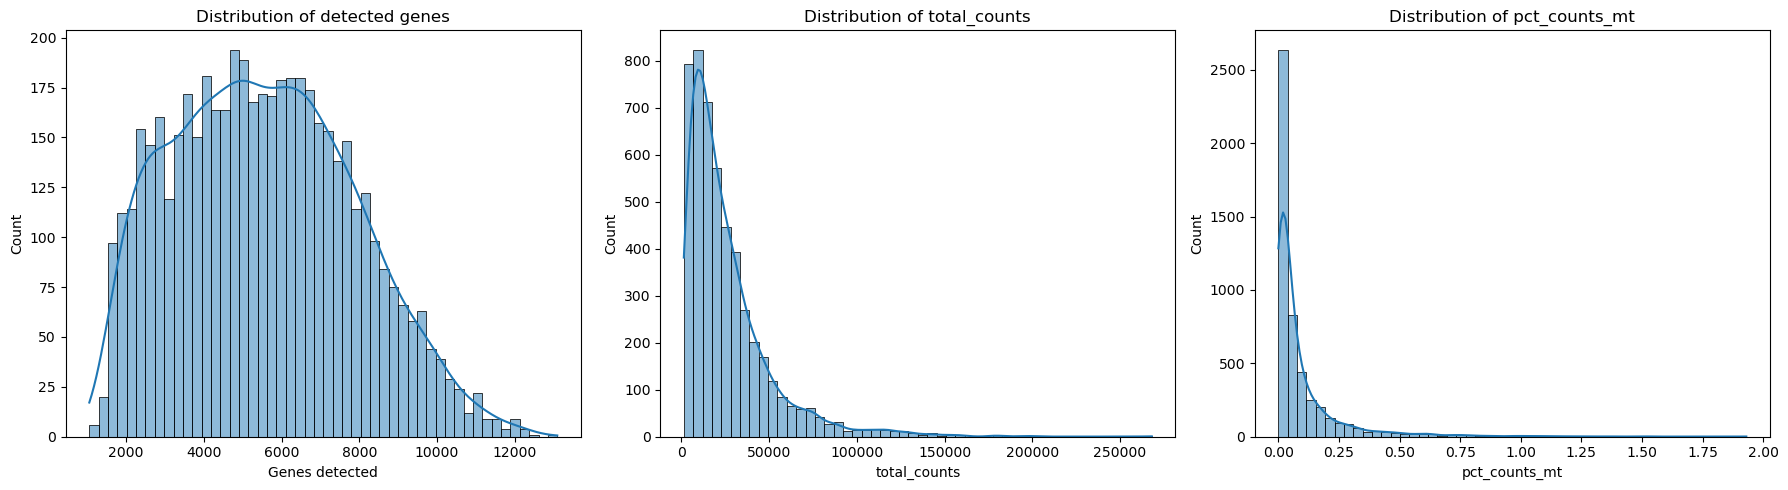

In [9]:
# Histograms to visualize the data distribution  
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(adata_sample.obs["Genes detected"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of detected genes")

sns.histplot(adata_sample.obs["total_counts"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribution of total_counts")

sns.histplot(adata_sample.obs["pct_counts_mt"], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Distribution of pct_counts_mt")

plt.tight_layout()
plt.show()

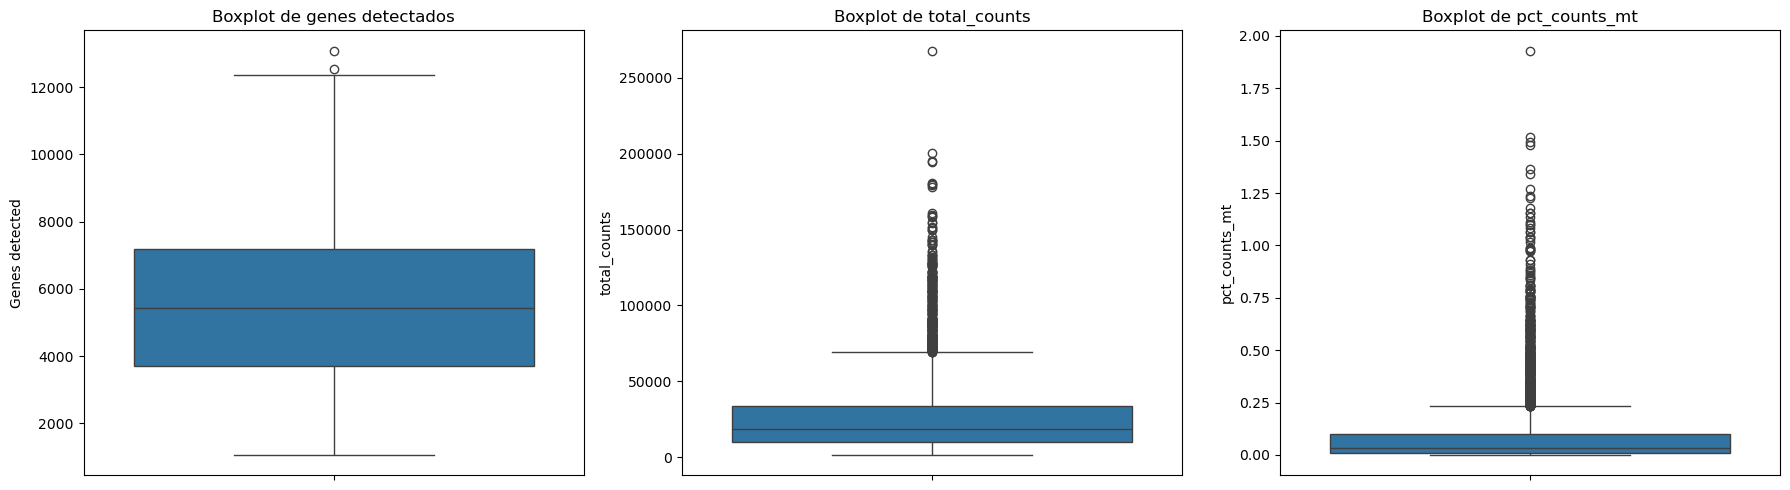

In [10]:
# Boxplots to visualize outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(y=adata_sample.obs["Genes detected"], ax=axes[0])
axes[0].set_title("Boxplot de genes detectados")

sns.boxplot(y=adata_sample.obs["total_counts"], ax=axes[1])
axes[1].set_title("Boxplot de total_counts")

sns.boxplot(y=adata_sample.obs["pct_counts_mt"], ax=axes[2])
axes[2].set_title("Boxplot de pct_counts_mt")

plt.tight_layout()
plt.show()

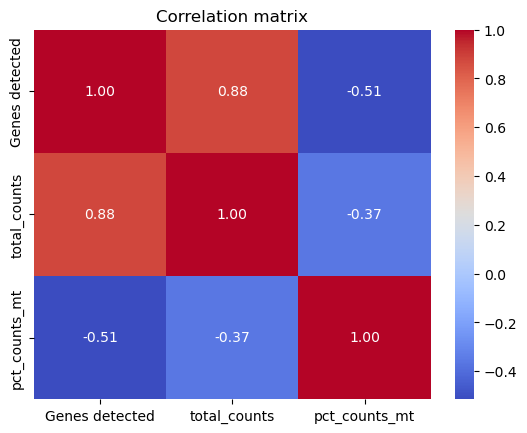

In [11]:
# Correlation matrix between variables  
corr_matrix = adata_sample.obs[["Genes detected", "total_counts", "pct_counts_mt"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix")
plt.show()

In [12]:
# Display the first columns of adata_sample.var to look for useful labels  
print(adata_sample.var.columns)

Index(['feature_is_filtered', 'feature_name', 'feature_reference',
       'feature_biotype', 'feature_length', 'feature_type', 'mt'],
      dtype='object')


In [13]:
# Automatically filter out mitochondrial genes  
adata_sample = adata_sample[:, ~adata_sample.var["mt"]]

# Confirm that the filtering was successful  
print(f"Number of genes after filtering: {adata_sample.shape[1]}")


Number of genes after filtering: 36399


In [14]:
# Make a real copy to avoid warnings when modifying .obs  
adata_sample = adata_sample.copy()

# Recalculate the total expression without mitochondrial genes  
adata_sample.obs["total_counts"] = adata_sample.X.sum(axis=1)

# Assign a new mitochondrial expression percentage (should be 0 in all cells)  
adata_sample.obs["pct_counts_mt"] = 0.0

# Verify that it is indeed 0 in all cells  
print(adata_sample.obs["pct_counts_mt"].describe())


count    5000.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: pct_counts_mt, dtype: float64


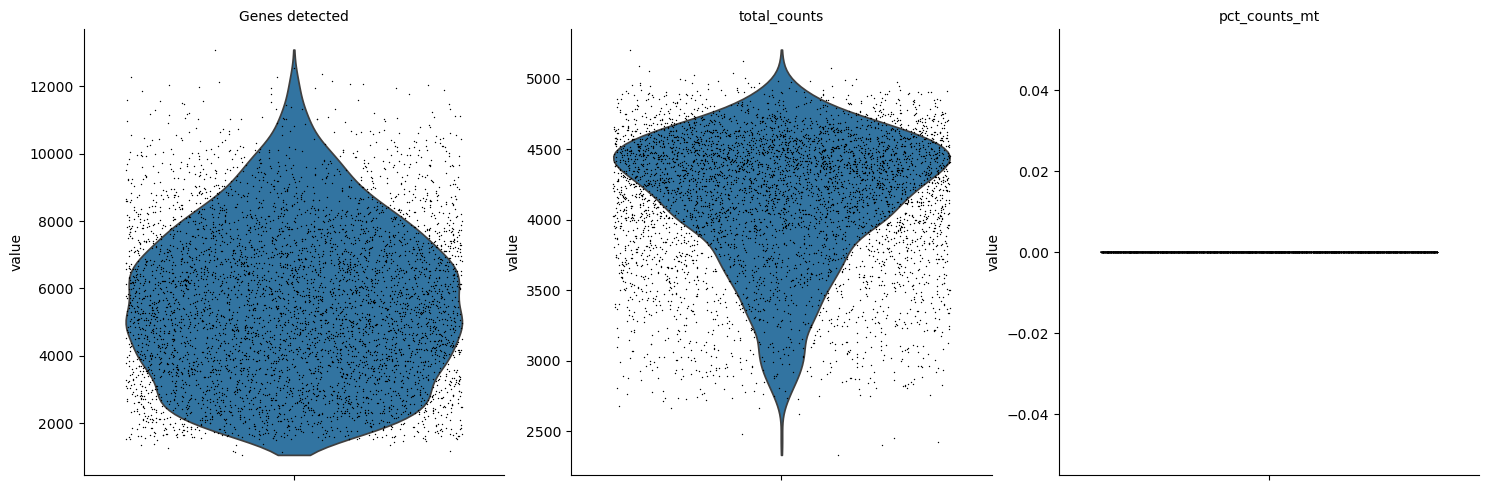

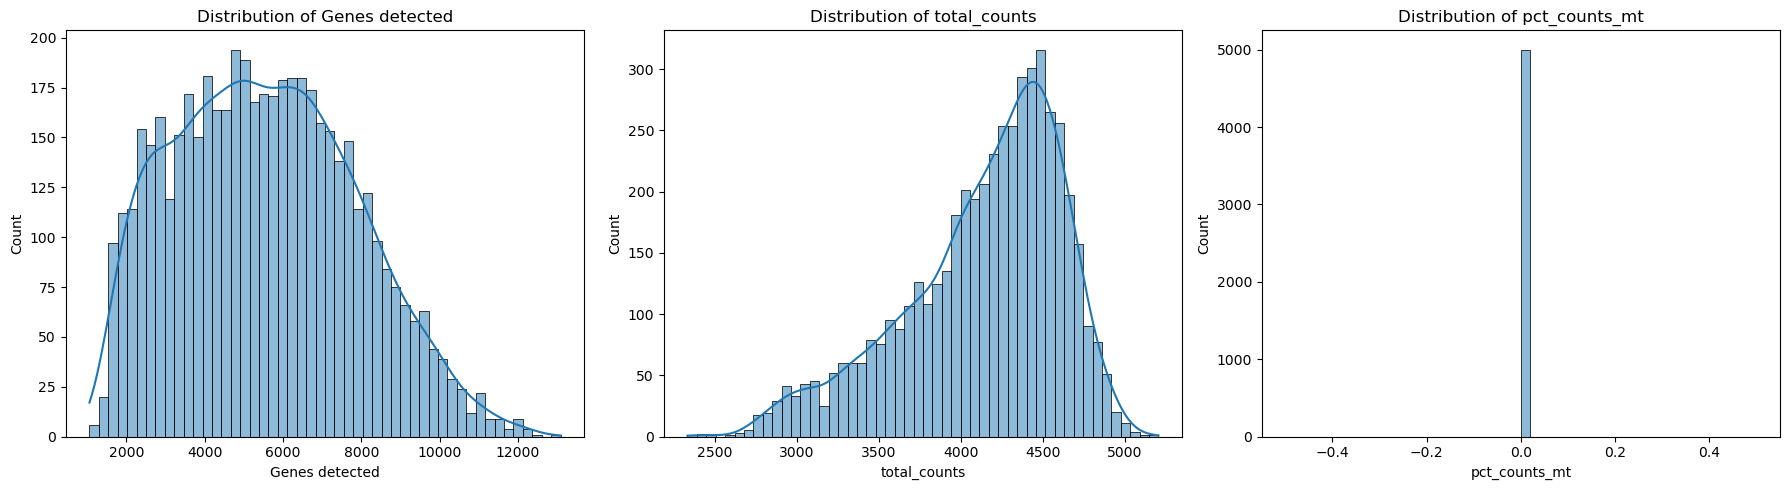

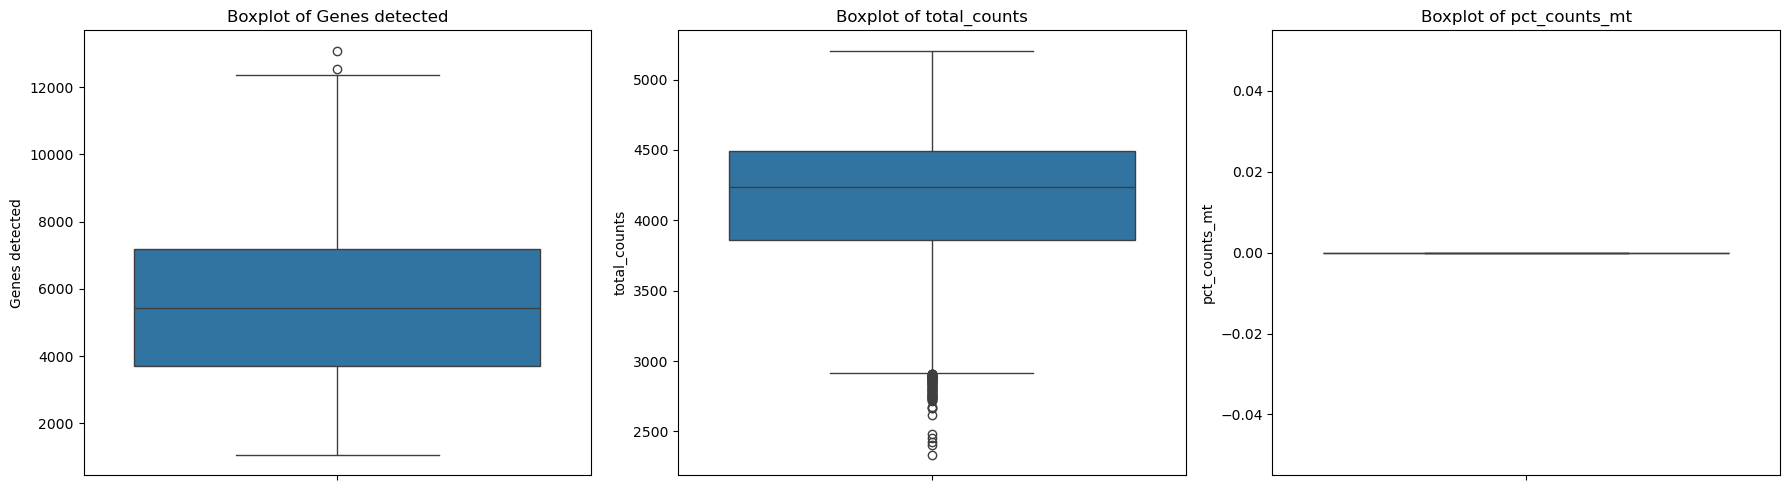

In [15]:
# Visualize metrics after mitochondrial gene filtering  
sc.pl.violin(
    adata_sample,
    ["Genes detected", "total_counts", "pct_counts_mt"],
    jitter=0.4, multi_panel=True
)

# Plot updated histograms  
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(["Genes detected", "total_counts", "pct_counts_mt"]):
    sns.histplot(adata_sample.obs[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

# Plot updated boxplots  
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(["Genes detected", "total_counts", "pct_counts_mt"]):
    sns.boxplot(y=adata_sample.obs[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


In [16]:
# Display quantiles for Genes detected and total_counts  
print(adata_sample.obs[["Genes detected", "total_counts"]].quantile([0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]))

      Genes detected  total_counts
0.01         1607.00   2848.612712
0.05         2058.90   3154.600732
0.25         3703.00   3860.139832
0.50         5434.00   4238.342041
0.75         7180.25   4493.430664
0.95         9569.10   4747.054053
0.99        11031.10   4903.464834


Number of cells after filtering: 4779


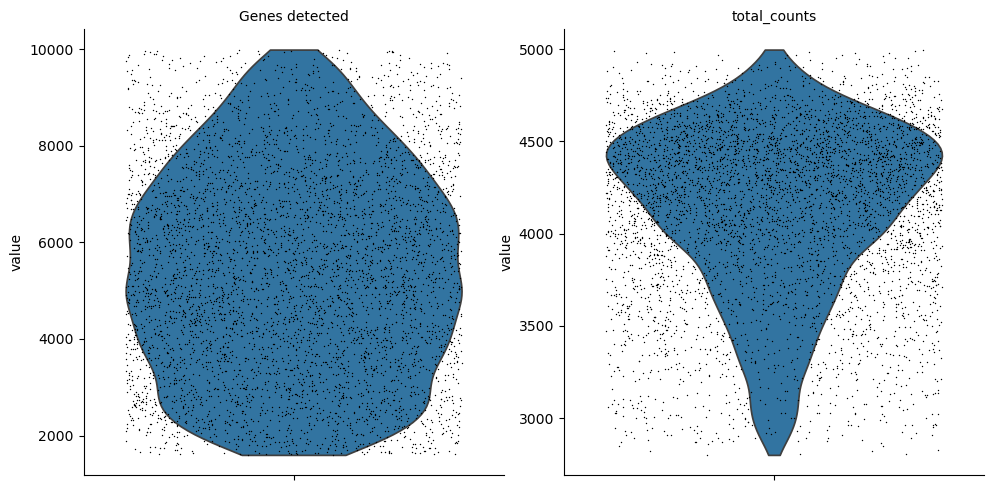

       Genes detected  total_counts
count     4779.000000   4779.000000
mean      5410.445909   4133.562012
std       2099.181390    459.170715
min       1602.000000   2801.148193
25%       3702.500000   3856.825073
50%       5361.000000   4226.153320
75%       7017.500000   4479.894531
max       9989.000000   4996.774414


In [17]:
# Define quality thresholds based on percentiles  
min_genes = 1600   # Filter cells with fewer than 1600 detected genes  
max_genes = 10000  # Filter cells with more than 10000 detected genes  
min_counts = 2800  # Filter cells with fewer than 2800 total_counts   
max_counts = 5000  # Filter cells with more than 5000 total_counts

# Apply filtering  
adata_sample = adata_sample[
    (adata_sample.obs["Genes detected"] > min_genes) &
    (adata_sample.obs["Genes detected"] < max_genes) &
    (adata_sample.obs["total_counts"] > min_counts) &
    (adata_sample.obs["total_counts"] < max_counts)
]

# Confirm the number of cells after filtering  
print(f"Number of cells after filtering: {adata_sample.shape[0]}")

# Visualize the distribution after filtering  
sc.pl.violin(
    adata_sample, ["Genes detected", "total_counts"], 
    jitter=0.4, multi_panel=True
)

# Generate descriptive statistics after filtering    
print(adata_sample.obs[["Genes detected", "total_counts"]].describe())


In [18]:
# Convert to an explicit copy to avoid warnings  
adata_sample = adata_sample.copy()

# Total normalization (without log transformation)  
sc.pp.normalize_total(adata_sample, target_sum=1e4, inplace=True)

print("Normalization applied successfully.")

Normalization applied successfully.


In [ ]:
# Check descriptive statistics of the normalized expression matrix  
stats = pd.DataFrame(adata_sample.X.A if hasattr(adata_sample.X, "A") else adata_sample.X).describe()
print(stats)

In [ ]:
# Create histograms to see the distribution of expression after normalization  
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(adata_sample.obs["Genes detected"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of detected genes after normalization")

sns.histplot(adata_sample.obs["total_counts"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribution of total_counts after normalization")

plt.show()


In [ ]:
# Create boxplots to visualize the data dispersion after normalization  
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(y=adata_sample.obs["Genes detected"], ax=axes[0])
axes[0].set_title("Boxplot of detected genes after normalization")

sns.boxplot(y=adata_sample.obs["total_counts"], ax=axes[1])
axes[1].set_title("Boxplot of total_counts after normalization")

plt.show()


In [ ]:
# Calculate the correlation matrix  
corr_matrix = adata_sample.obs[["Genes detected", "total_counts"]].corr()

# Plot the correlation matrix   
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation matrix after normalization")
plt.show()
